In [1]:
import pandas as pd
import re
import nltk
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import numpy as np

ModuleNotFoundError: No module named 'spacy'

In [ ]:
# data = pd.read_csv("/content/drive/MyDrive/DebateGovRS_Anotado.csv")
data = pd.read_csv('DebateGovRS_Anotado.xlsx - DebateGovRS_Anotado.csv')


In [ ]:
data.head(15)

,author_id,created_at,id,lang,retweet_count,text,sinal
0,"1,46E+18",2022-08-08T01:08:23Z,"1,56E+18",pt,45,RT @EdegarPretto O meu candidato vice-governad...,1.0
1,"1,51E+18",2022-08-08T01:08:23Z,"1,56E+18",pt,0,Periga o Argenta chamar o Simon pra responder ...,NaN
2,"1,06E+18",2022-08-08T01:08:21Z,"1,56E+18",pt,14,RT @WinstonLing Segue o link para assistirem o...,1.0
3,"7,15E+17",2022-08-08T01:08:20Z,"1,56E+18",pt,88,RT @EdegarPretto Eu quero dizer aos gaúchos e ...,NaN
4,1455004730,2022-08-08T01:08:20Z,"1,56E+18",pt,0,@wmfigueiredo @evertonvf @bandrs @EduardoLeite...,0.0
5,"1,23E+18",2022-08-08T01:08:20Z,"1,56E+18",und,0,@EduardoLeite_ 🤡,0.0
6,116829646,2022-08-08T01:08:19Z,"1,56E+18",pt,41,Nós já governamos o Rio Grande Sul com @olivio...,0.0
7,337744562,2022-08-08T01:08:18Z,"1,56E+18",pt,1,Onyx Caixa 2 confesso não pode falar em corrup...,0.0
8,2336691999,2022-08-08T01:08:17Z,"1,56E+18",pt,0,@onyxlorenzoni Essa gente de bem é mesma que é...,0.0
9,176570576,2022-08-08T01:08:17Z,"1,56E+18",pt,31,RT @LeonelRadde @EdegarPretto demolindo o Onyx...,0.0


In [ ]:
data.drop(['author_id', 'created_at', 'id', 'lang', 'retweet_count'],1, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   text    3000 non-null   object 
 1   sinal   1372 non-null   float64
dtypes: float64(1), object(1)
memory usage: 47.0+ KB


In [ ]:
duplicados = round(sum(data.duplicated("text"))/len(data)*100,2)
print(f'Tweets com texto duplicado: {duplicados}%.')

Tweets com texto duplicado: 39.43%.


In [ ]:
data.drop_duplicates("text", inplace=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1817 entries, 0 to 2996
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   text    1817 non-null   object 
 1   sinal   1817 non-null   float64
dtypes: float64(1), object(1)
memory usage: 42.6+ KB


In [ ]:
#Acrescentando o valor 2 para identificar os neutros
data ['sinal'] = data ['sinal']. fillna (2)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


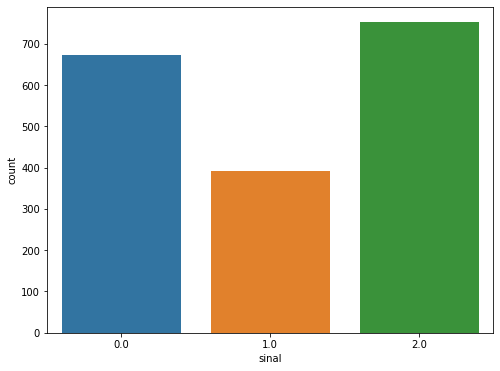

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(data['sinal'])
plt.show()

In [ ]:
# importando a lista da nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stopwords_pt = stopwords.words("portuguese")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# remove 'nao' e 'nem' da lista
stopwords_pt.remove('não')
stopwords_pt.remove('nem')

In [ ]:
import spacy.cli
spacy.cli.download("pt_core_news_sm")

✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


In [ ]:
import pt_core_news_sm

spc_pt = pt_core_news_sm.load()

/usr/local/lib/python3.7/dist-packages/spacy/language.py:1899: UserWarning: [W123] Argument disable with value [] is used instead of ['senter'] as specified in the config. Be aware that this might affect other components in your pipeline.
  config_value=config["nlp"][key],


In [ ]:
def limpa_texto(texto):
  '''(str) -> str
  Essa funcao recebe uma string, deixa tudo em minusculo, filtra apenas letras,
  retira stopwords, lemmatiza e retorna a string resultante.
  '''
  texto = texto.lower()

  texto = re.sub(r"[\W\d_]+", " ", texto)

  texto = [pal for pal in texto.split() if pal not in stopwords_pt]

  spc_texto = spc_pt(" ".join(texto))
  tokens = [word.lemma_ if word.lemma_ != "-PRON-" else word.lower_ for word in spc_texto]

  return " ".join(tokens)

In [ ]:
# Aplica a funcao nas reviews do dataset
data['text'] = data['text'].apply(limpa_texto)

data = data[data['text'] != '']

In [ ]:
# Importando o CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Instanciando o CountVectorizer, binary=True faz a codificacao binaria
vectorizer = CountVectorizer(binary=True, max_features=5000)

texto = data['text']

# Vetorizando o texto
X_bow = vectorizer.fit_transform(texto)

In [ ]:
# Importando o TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Instanciando o TfidfVectorizer
tfidf_vect = TfidfVectorizer(max_features=5000)

# Vetorizando
X_tfidf = tfidf_vect.fit_transform(texto)

In [ ]:
from sklearn.model_selection import train_test_split

X1_train, X1_test, y1_train, y1_test = train_test_split(X_bow, data['sinal'],
                                                        test_size=0.3, random_state = 10)

X2_train, X2_test, y2_train, y2_test = train_test_split(X_tfidf, data['sinal'],
                                                        test_size=0.3, random_state = 10)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score, recall_score, precision_score

def mostra_metricas(y_true, y_pred):
  ''' Função que recebe o y real, o y predito e mostra as
  principais metricas.
  '''
  print("Acurácia: ", accuracy_score(y_true, y_pred))
  print("\nF1-Score:", f1_score(y_true, y_pred, average='weighted'))
  print("\nRecall:", recall_score(y_true, y_pred, average='weighted'))
  print("\nPrecision:", precision_score(y_true, y_pred, average='weighted'))
  print("\nMatriz de confusão:")
  sns.heatmap(confusion_matrix(y_true, y_pred), annot=True)
  plt.show()

In [ ]:
#Import knearest neighbors Classifier model
from sklearn.neighbors import KNeighborsClassifier

#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5)

#Train the model using the training sets
knn.fit(X1_train, y1_train)

#Predict the response for test dataset
y_pred = knn.predict(X1_test)

Acurácia:  0.4267399267399267

F1-Score: 0.34825377809532193

Recall: 0.4267399267399267

Precision: 0.4639650796269407

Matriz de confusão:


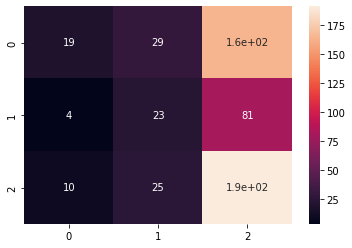

In [ ]:
mostra_metricas(y1_test, y_pred )

In [ ]:
# Importando a regressao logistica da sklearn
from sklearn.linear_model import LogisticRegression

# Instanciando a reg. logistica
reglog = LogisticRegression()

# Aplicando o modelo
reglog.fit(X1_train, y1_train)

# Predicao
y1_reglog_pred = reglog.predict(X1_test)

Acurácia:  0.6007326007326007

F1-Score: 0.6004227004348872

Recall: 0.6007326007326007

Precision: 0.6028257456828885

Matriz de confusão:


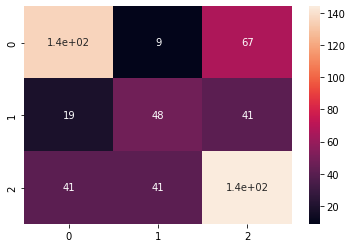

In [ ]:
mostra_metricas(y1_test, y1_reglog_pred)

In [ ]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(random_state=1, max_iter=300).fit(X1_train, y1_train)

clf_pred = clf.predict(X1_test)

Acurácia:  0.575091575091575

F1-Score: 0.5762835177891964

Recall: 0.575091575091575

Precision: 0.5791403921408632

Matriz de confusão:


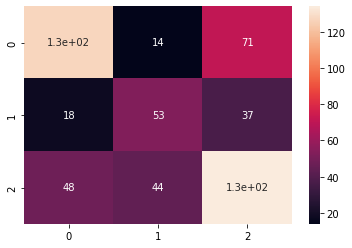

In [ ]:
mostra_metricas(y1_test, clf_pred )

In [ ]:
from sklearn.svm import LinearSVC

clf = LinearSVC(random_state=0, tol=1e-5)

lsvc = clf.fit(X1_train, y1_train)

lsvc_pred = lsvc.predict(X1_test)

Acurácia:  0.5677655677655677

F1-Score: 0.568294031872374

Recall: 0.5677655677655677

Precision: 0.5703847581201148

Matriz de confusão:


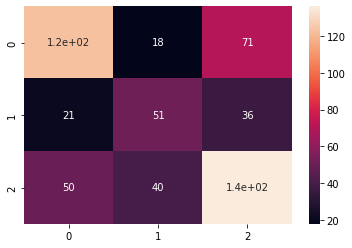

In [ ]:
mostra_metricas(y1_test, lsvc_pred )

In [ ]:
reglog2 = LogisticRegression()
reglog2.fit(X2_train, y2_train)
y2_reglog_pred = reglog2.predict(X2_test)

Acurácia:  0.6318681318681318

F1-Score: 0.6190765486932733

Recall: 0.6318681318681318

Precision: 0.6274701146152596

Matriz de confusão:


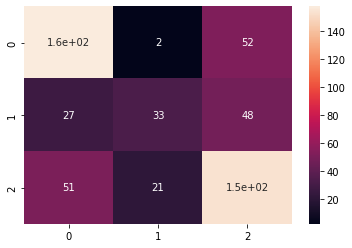

In [ ]:
mostra_metricas(y2_test, y2_reglog_pred)

In [ ]:
def nova_predicao(texto):
  '''Funcao que recebe uma string e printa a predicao feita
  pelo modelo reglog2.'''
  texto_vetorizado = tfidf_vect.transform([texto])
  pred = reglog2.predict(texto_vetorizado)

  if pred == 0:
    print("Negativo.")
  elif pred == 1:
    print("Positivo.")
  elif pred == 2:
    print("Neutro.")
  else:
    print("Não sei")

In [ ]:
nova_predicao("@EdegarPretto O meu candidato vice-governador é o @PedroRuasPsol fundador trabalhismo e defensor da escola integral de Leonel Bri")

Positivo.


In [ ]:
nova_predicao("Roberto Argenta lutando contra o pigarro")

Neutro.


In [ ]:
nova_predicao("Onix caixa dois confesso não pode falar de corrupção")

Negativo.
